<h2> Data extraction</h2>


Time-series data for 4 different strains of E.coli bacteria are extracted from the database uploaded by Wang.et al. on Suckjoon Jun's lab website. The four strains are namely; E.coli b/r SJ108, E.coli b/r SJ109, E.coli MG1655 (CGSC 6300) and E.coli MG1655 lexA3



In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm
import os
import math
spacer = '-------------'

 The timeseries need to be folded onto each other based on the division time. This folding needs to be done before the concatanation, since at t=0, division=0. As a file is concatanated, the final few lines merge with the beginning, and it gives false data.

To fold the plots, for each file, I will open the file, and read it, and modulo the time based on the time of division. This way each time division=1, the next few times will be modulo'ed with the time at which the latest division took place. Hopefully this will result in the appropriate folding. All variables will be reset for each new file, so that there is no overlap of data or false concatanation.

In [2]:
# # Data extraction
# FilePaths = []
# time = []
# length = []
# width = []
# strain = './full_data/E. coli B:r SJ108 and SJ119/20090412 SJ108'
# # strain = './full_data/E. coli B:r SJ108 and SJ119/20090529 SJ119'
# # strain = './full_data/E. coli MG1655 (CGSC 6300)'
# # strain = './full_data/E. coli MG1655 lexA3/'

# for path, folder, file in os.walk(strain):
#     counter = 0
#     for filename in file:
#         if(filename.endswith('.dat')):
#             FilePaths.append(os.path.join(path,filename))
#             df = pd.read_csv(FilePaths[-1], sep = ' ')
#             df.rename(columns={'index':'time'}, inplace=True)

#             # -----------------------------------------------------------------------------------
#             # sometimes at t=0, division != 0. We need to set it to 1 to tell the code that a
#             # new time-series starts from here.
#             for i, j in enumerate(df.loc[:,'time']):
#                 if (j == 0):
#                     df.loc[i,'division'] = 1
#             # beginning of files should assume a new cell
#             df.loc[0,'division'] = 1
#             # -----------------------------------------------------------------------------------


#             # Folding the time axis so that all divisions occur at t=0: 
#             t = []
#             l = []
#             w = []
#             for i,j in enumerate(df.loc[:,'time']):
#                 # Defining division time: 
#                 if(df.loc[i,'division']==1):
#                     divisionTime = df.loc[i,'time']
                
#                 # Fold the time series based on division time
#                 if (divisionTime == 0):
#                     t.append(df.loc[i,'time'])
#                 else:
#                     t.append(df.loc[i,'time']%divisionTime)
                

#                 w.append(0.0645*df.loc[i,'width'])
#                 l.append(0.0645*df.loc[i,'length'])
            
#             time.extend(t)
#             length.extend(l)
#             width.extend(w)

        
# # data_frame = pd.concat(data_frame, ignore_index=True)


There may be a logical issue in this code; division time needs to be measured after, not before the series. 

<h1> Data extraction to keep doubling-time information </h1>

In [3]:
strain = 0
FilePaths = []
time = []
length = []
width = []
strain_name = ['B-r SJ108', 'B-r SJ119', 'CGSC 6300', 'MG1655 lexA3']
strain_path = []
strain_path.append('./full_data/E. coli B:r SJ108 and SJ119/20090412 SJ108')
strain_path.append('./full_data/E. coli B:r SJ108 and SJ119/20090529 SJ119')
strain_path.append('./full_data/E. coli MG1655 (CGSC 6300)')
strain_path.append('./full_data/E. coli MG1655 lexA3/')

for path, folder, file in os.walk(strain_path[strain]):
    for filename in file:
        if(filename.endswith('.dat')):
            FilePaths.append(os.path.join(path,filename))
            df = pd.read_csv(FilePaths[-1], sep = ' ')
            df.rename(columns={'index':'time'}, inplace=True)
            # -----------------------------------------------------------------------------------
            # sometimes at t=0, division != 0. We need to set it to 1 to tell the code that a
            # new time-series starts from here.
            for i, j in enumerate(df.loc[:,'time']):
                if (j == 0):
                    df.loc[i,'division'] = 1
            # beginning of files should assume a new cell
            df.loc[0,'division'] = 1
            # -----------------------------------------------------------------------------------

            cell_groupsroups = df.groupby((df['division'] == 1).cumsum())
            for i, group in cell_groupsroups:
                divisionTime = group.iloc[-1,0]- group.iloc[0,0]

                # Scrubbing the data, and extending the dimension list

                
                if 10<divisionTime<35: # Time period filtering 
                    l=0.0645*group['length']
                    w = 0.0645*group['width']
                    t = (group['time'] - group.iloc[0,0])
                    if (not any(value > 1.0 for value in w)) and (not any(value <= 0 for value in w)): # Filter 2
                        if (not any(value>20 for value in l)):
                            length.extend(l)
                            time.extend(t)
                            width.extend(w)
                    # plt.scatter(t, w)
                    # plt.show()
                    
                

                

<function matplotlib.pyplot.show(close=None, block=None)>

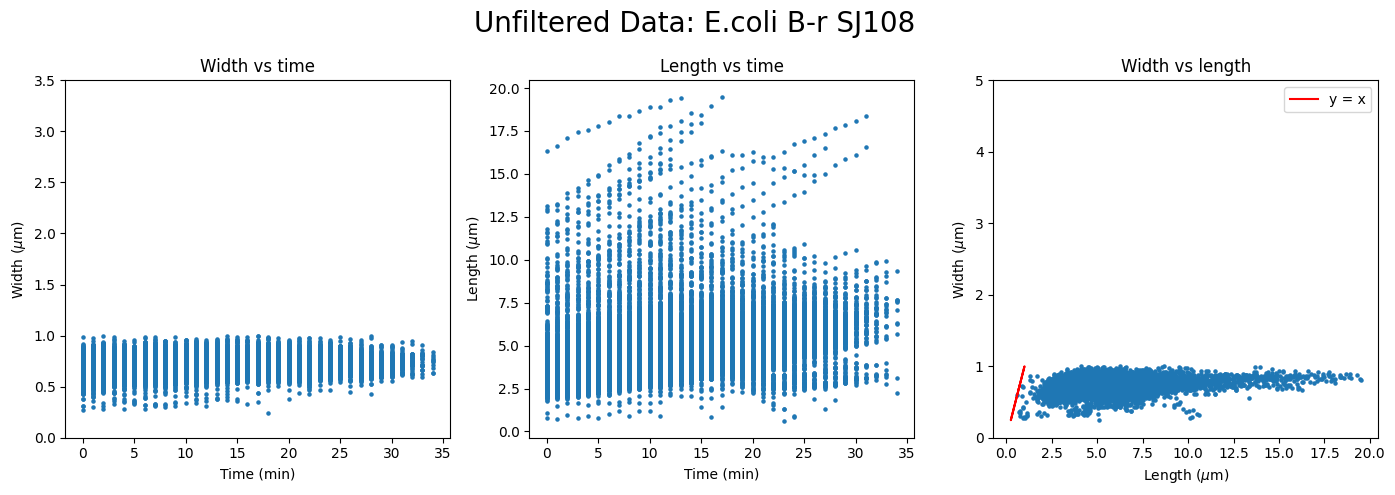

In [4]:
# Scatter plotting extracted data:

plt.figure(figsize = (14,5))

plt.subplot(1,3,1)
plt.scatter(time, width, s=5)
plt.title('Width vs time')
plt.xlabel('Time (min)')
plt.ylim(0,3.5)
plt.ylabel(r'Width ($\mu$m)')


plt.subplot(1,3,2)
plt.scatter(time, length, s=5)
plt.title('Length vs time')
plt.xlabel('Time (min)')
plt.ylabel(r'Length ($\mu$m)')



plt.subplot(1,3,3)
plt.scatter(length, width, s=5)
plt.plot(width,width, color = 'red', label = 'y = x')
plt.xlabel(r'Length ($\mu$m)')
plt.ylabel(r'Width ($\mu$m)')
plt.ylim(0,5)
plt.legend()
plt.title('Width vs length')

plt.suptitle(f'Unfiltered Data: E.coli {strain_name[strain]}', fontsize = 20)
plt.tight_layout()
plt.show

We may need another layer of data scrubbing, since we can see that there multiple cells that seem to have a width greater 1.5 um. The width of the channel in the mother machine is 1.5um, and so these must be segmentation errors. 

We will only consider cells whos widths are less 1.5. The following block of code does this kind of a scrubbing.

In [5]:
# Filter 2: Widths <= 1.5... 
combined_database = {
    'time': time,
    'length': length,
    'width': width
}
combined_database = pd.DataFrame(combined_database)
condition_mask = (0 < combined_database['width']) & (combined_database['width'] <= 1.5)
filter2_database = combined_database[condition_mask]

time2 = filter2_database['time']
length2 = filter2_database['length']
width2 = filter2_database['width']


In [6]:
# # Scatter plotting extracted data:

# plt.figure(figsize = (14,5))

# plt.subplot(1,3,1)
# plt.scatter(time2, width2, s=5)
# plt.title('Width vs time')
# plt.xlabel('Time (min)')
# plt.ylim(0,3.5)
# plt.ylabel(r'Width ($\mu$m)')


# plt.subplot(1,3,2)
# plt.scatter(time2, length2, s=5)
# plt.title('Length vs time')
# plt.xlabel('Time (min)')
# plt.ylabel(r'Length ($\mu$m)')



# plt.subplot(1,3,3)
# plt.scatter(length2, width2, s=5)
# plt.plot(width,width, color = 'red', label='y = x')
# plt.xlabel(r'Length ($\mu$m)')
# plt.ylabel(r'Width ($\mu$m)')
# plt.ylim(0,5)
# plt.legend()
# plt.title('Width vs length')

# plt.suptitle(f'Width-filtered Data: E.coli {strain_name[q]}', fontsize = 20)
# plt.tight_layout()

# plt.show

<h3>Plotting extracted data</h3>

In [7]:
# # 2D density plot for length and width with time
# # Length
# plt.figure(figsize = (14,4))

# plt.subplot(1,3,1)
# sns.kdeplot(x = time, y = length, cmap = 'Reds', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,35)
# plt.ylim(0,10)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Length ($\mu$m)')
# # plt.title(f'Length time-series: {strain_name[q]}')

# # Width
# plt.subplot(1,3,2)
# sns.kdeplot(x = time, y = width, cmap = 'Blues', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,35)
# plt.ylim(0.4,1)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Width ($\mu$m)')
# # plt.title(f'Width time-series: E. coli {strain_name[q]}')

# # Length vs Width
# plt.subplot(1,3,3)
# sns.kdeplot(x = length, y = width, cmap = 'cool', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,10)
# plt.ylim(0.4,1)
# plt.xlabel(r'Length $\mu$m')
# plt.ylabel(r'Width ($\mu$m)')
# # plt.title(f'Length-Width correlation: E. coli {strain_name[q]}')

# plt.suptitle(f'Unfiltered Data:  E. coli {strain_name[q]}', fontsize = 20)
# plt.tight_layout()

# plt.show()



In [8]:
# # 2D density plot for length and width with time
# plt.figure(figsize = (14,4))
# # Length
# plt.subplot(1,3,1)
# sns.kdeplot(x = time2, y = length2, cmap = 'Reds', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,35)
# plt.ylim(0,10)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Length ($\mu$m)')
# # plt.title(f'Length time-series: E. coli {strain_name[q]}')

# # Width
# plt.subplot(1,3,2)
# sns.kdeplot(x = time2, y = width2, cmap = 'Blues', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,35)
# plt.ylim(0.4,1)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Width ($\mu$m)')
# # plt.title(f'Width time-series: E. coli {strain_name[q]}')

# # Length vs Width
# plt.subplot(1,3,3)
# sns.kdeplot(x = length2, y = width2, cmap = 'cool', fill = True, bw_adjust = 1, cbar = True, cbar_kws={'label':'Density'})
# plt.xlim(0,10)
# plt.ylim(0.4,1)
# plt.xlabel(r'Length $\mu$m')
# plt.ylabel(r'Width ($\mu$m)')
# # plt.title(f'Length-Width correlation: E. coli {strain_name[q]}')

# plt.suptitle(f'Filtered Data:  E. coli {strain_name[q]}', fontsize = 20)
# plt.tight_layout()
# plt.show()


<h2>Binning the data</h2>

The next part of the code bins the data in time: for example, one bin will be t=0 to t=1, and so on. I am going to take a constant binwidth. 

To make the coding easier, I think first sorting the data so that it is chronological will help: 

<h3>Sorting</h3>

In [9]:
# sorting data using zip()

# combining the lists to maintain the correlation
combined_data2 = list(zip(time2, length2, width2))
# sorting
sorted_combined_data = sorted(combined_data2, key = lambda x:x[0])
# unzipping
time_, length_, width_ = zip(*sorted_combined_data)


In [10]:
# # Sanity check: comparing sorted and unsorted plots: 

# # Length: 
# plt.scatter(time2, width2,1, alpha = 1)
# plt.title(f'width E.coli {strain_name[q]}: Unsorted')
# plt.xlabel('Time (min)')
# plt.ylabel('width $\mu$m')
# plt.show()
# plt.scatter(time_, width_,1, alpha = 1)
# plt.title(f'width E.coli {strain_name[q]}: Sorted')
# plt.xlabel('Time (min)')
# plt.ylabel('width $\mu$m')
# plt.show()

At this step maybe we can do a simple cleanup of the data: ignoring the time-series that goes beyonf t=50 min, which is physiologically very improbable.

Here, 'time_' is the sorted 'time', along with the corresponding 'length_' and 'width_'

<h3>Binning</h3>

In [11]:
# Setting the binwidth to 2min, can be changed later
binwidth = 2 # min
ub = max(time_) # upper bound of time
lb = min(time_) # lower bound of time
# 
index = []
for i in range(0,ub+1,binwidth):
    index.append(time_.index(i))

meanBinnedTime = []
meanBinnedLength = []
meanBinnedWidth = []
stdBinnedTime = []
stdBinnedLength = []
stdBinnedWidth = []
for i in range(0,len(index)-1):
    meanBinnedTime.append(np.mean(time_[index[i]:index[i+1]]))
    stdBinnedTime.append(np.std(time_[index[i]:index[i+1]]))

    meanBinnedLength.append(np.mean(length_[index[i]:index[i+1]]))
    stdBinnedLength.append(np.std(length_[index[i]:index[i+1]]))

    meanBinnedWidth.append(np.mean(width_[index[i]:index[i+1]]))
    stdBinnedWidth.append(np.std(width_[index[i]:index[i+1]]))


<h3> Plotting </h3>

In [12]:

# plt.figure(figsize = (8,4))

# plt.subplot(1,2,1)
# # Length binned plot 
# plt.errorbar(meanBinnedTime, meanBinnedLength, xerr = stdBinnedTime, yerr = stdBinnedLength, fmt = 'o', markersize = 2, color = 'k',ecolor = 'r',linewidth= 1, label = 'Mean length per bin')
# for i in index:
#     plt.axvline(time_[i], linestyle = '--', color = 'k', linewidth = 0.5, alpha = 0.2)
# plt.xlim(0,ub)
# plt.ylim(0,9)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Length ($\mu$m)')
# # plt.title('Length')
# plt.legend()

# plt.subplot(1,2,2)
# # Width binned plot
# plt.errorbar(meanBinnedTime, meanBinnedWidth, xerr = stdBinnedTime, yerr = stdBinnedWidth, fmt = 'o', markersize = 2, color = 'k',ecolor = 'b',linewidth= 1, label = 'Mean width per bin')
# for i in index:
#     plt.axvline(time_[i], linestyle = '--', color = 'k', linewidth = 0.5, alpha = 0.2)
# plt.xlim(0,ub)
# # plt.ylim(0,2)
# plt.xlabel('Time (min)')
# plt.ylabel(r'Width ($\mu$m)')
# # plt.title('Width')
# plt.legend()

# plt.suptitle(f'Binned mean lengths and widths: E.coli {strain_name[strain]} ', fontsize = 20)
# plt.tight_layout()

# plt.show()

In [13]:
# # Saving parsed data in csv files

# # First, we merge the length, width and time lists into a pandas dataframe:
# output_dict = {
#     'time' : meanBinnedTime,
#     'length': meanBinnedLength,
#     'width' : meanBinnedWidth
# }
# output_df = pd.DataFrame(output_dict)

# # Then, we output them as csv files
# output_df.to_csv(f'{strain_name[q].replace(" ","_")}___[{binwidth}min].csv', index = False)

In [14]:
# # Saving parsed error data in csv files

# # First, we merge the length, width and time lists into a pandas dataframe:
# output_errors_dict = {
#     'time_err' : stdBinnedTime,
#     'length_err': stdBinnedLength,
#     'width_err' : stdBinnedWidth
# }
# err_df = pd.DataFrame(output_errors_dict)

# # Then, we output them as csv files
# output_df.to_csv(f'{strain_name[q].replace(" ","_")}___[{binwidth}min]_error_.csv', index = False)

In [24]:
FilePaths = []
time = []
length = []
width = []
perCellLength = []
perCellWidth = []
strain_name = ['B/r SJ108', 'B/r SJ119', 'CGSC 6300', 'MG1655 lexA3']
strain_path = []
NumberOfCellsPerPeriod = [0]* 30
strain_path.append('./full_data/E. coli B:r SJ108 and SJ119/20090412 SJ108')
strain_path.append('./full_data/E. coli B:r SJ108 and SJ119/20090529 SJ119')
strain_path.append('./full_data/E. coli MG1655 (CGSC 6300)')
strain_path.append('./full_data/E. coli MG1655 lexA3/')

for path, folder, file in os.walk(strain_path[strain]):
    for filename in file:
        if(filename.endswith('.dat')):
            FilePaths.append(os.path.join(path,filename))
            df = pd.read_csv(FilePaths[-1], sep = ' ')
            df.rename(columns={'index':'time'}, inplace=True)
            # -----------------------------------------------------------------------------------
            # sometimes at t=0, division != 0. We need to set it to 1 to tell the code that a
            # new time-series starts from here.
            for i, j in enumerate(df.loc[:,'time']):
                if (j == 0):
                    df.loc[i,'division'] = 1
            # beginning of files should assume a new cell
            df.loc[0,'division'] = 1
            # -----------------------------------------------------------------------------------

            cell_groups = df.groupby((df['division'] == 1).cumsum())
            for i, group in cell_groups:
                divisionTime = group.iloc[-1,0]- group.iloc[0,0]

                # Scrubbing the data, and extending the dimension list

                if 15<=divisionTime< 35: # Time period filtering 
                    l=list(0.0645*group['length'])
                    w = list(0.0645*group['width'])
                    t = list((group['time'] - group.iloc[0,0]))
                    if (not any(value > 1.5 for value in w)) and (not any(value == 0 for value in w)): # Filter 2
                        perCellLength.append(l)
                        perCellWidth.append(w)
                
    


In [25]:
perCellLength

[[3.2288958,
  3.3566574000000005,
  3.4195062,
  3.5515119,
  3.5515635000000003,
  3.7450054500000003,
  3.9455811,
  4.06581555,
  4.13121855,
  4.33033005,
  4.52152095,
  4.71575625,
  4.65144975,
  5.10018915,
  5.0416038,
  5.36024025,
  5.49094305],
 [4.0664283,
  4.00193475,
  3.93998895,
  4.2635145,
  4.3915857,
  4.4582206499999995,
  4.78407465,
  4.845272250000001,
  4.97342085,
  5.295495150000001,
  5.42266335,
  5.43339615,
  5.8137526500000005,
  6.008374949999999,
  6.07052715,
  6.2048355],
 [4.131076650000001,
  4.0673184,
  4.3309686,
  4.2008076,
  4.582995899999999,
  4.518676500000001,
  4.846284900000001,
  4.7739417,
  5.03656635,
  5.35898895,
  5.5519794000000005,
  5.7458535,
  6.0100326,
  5.9437394999999995,
  6.200217299999999,
  6.39635535,
  6.6497565],
 [3.48620565,
  3.74621805,
  3.9378927,
  3.8802426,
  4.0670604,
  4.13444355,
  4.19964015,
  4.517573550000001,
  4.71149925,
  4.775102700000001,
  4.845130350000001,
  5.10596835,
  5.35959525,
 

In [27]:
DoublingTimeFreq = [0]*51

for i, j in enumerate(perCellLength):
    k = len(j)
    DoublingTimeFreq[k] = DoublingTimeFreq[k] + 1


Text(0, 0.5, 'Number of cells')

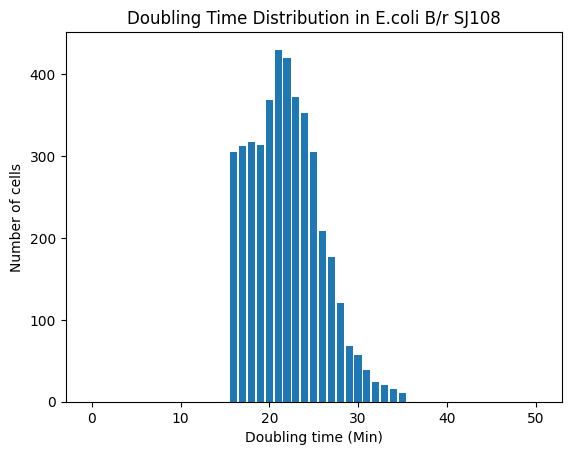

In [28]:
plt.bar(np.arange(0,51), DoublingTimeFreq)
plt.title(f'Doubling Time Distribution in E.coli {strain_name[strain]}')
plt.xlabel('Doubling time (Min)')
plt.ylabel('Number of cells')

In [19]:
sim_length = pd.read_csv('./Simulation_y/sim_lengh.csv', header = None)
sim_width = 2*pd.read_csv('./Simulation_y/sim_radius.csv', header = None)

In [20]:
# cmap = plt.get_cmap('cool')
# # for i, j in enumerate(perCellWidth):
# #     color = cmap(np.random.randint(0,255))
# #     plt.scatter(np.arange(0,len(j)), j, alpha = 0.3, edgecolor = 'none', color = color)

# for i in np.arange(0,2500):
#     j = np.random.randint(0,numOfCells)
#     color = cmap(np.random.randint(0,255))
#     plt.scatter(np.arange(0, len(perCellWidth[j])), perCellWidth[j], alpha = 0.3, edgecolor = 'none', color = color)

# plt.errorbar(meanBinnedTime, meanBinnedWidth, xerr = stdBinnedTime, yerr = stdBinnedWidth, fmt = 'x', markeredgewidth = 2, color = 'k',ecolor = 'k',linewidth= 1, label = 'Mean width per bin')
# plt.plot(np.arange(0,len(sim_width[strain])), sim_width[strain], linewidth = 1, color = 'r', linestyle = '--', label = 'simulation fit')
# plt.xlabel('Time (min)')
# plt.ylabel(r'Width ($\mu$m)')
# plt.title(f'E.coli {strain_name[strain]}')
# plt.legend(loc = 'upper right')
# plt.ylim(0,1.5)
# plt.show()

# # for i, j in enumerate(perCellLength):
# #     plt.scatter(np.arange(0,len(j)), j, alpha = 0.3, edgecolor = 'none')
# # plt.show()


Saving the matrix of PerCell data, to transfer to MATLAB for PSO. 


In [21]:
# Saving PerCellLenght, PerCellWidth

import csv
with open(f'perCellLength_{strain}.csv', 'w', newline = '') as csvfile: 
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(perCellLength)

with open(f'perCellWidth_{strain}.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(perCellWidth)